In [1]:
import numpy as np
import pandas as pd

from transformers import AutoTokenizer
NTDBGPT2_tokenizer = AutoTokenizer.from_pretrained('dracoglacius/NTDB-GPT2')

from utils import *
from mdf import *
from outputs import *

/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Overview

We have the intuition that given a distribution with center of the hyper-elliposid $c$ and the shape of the ellipsoid defined by $\Sigma$, $c$ and $\sigma$ should not deviate from the empirical mean ($\hat{c}$) and the covariance estimations ($\hat{\Sigma}$) taken from the training data. 

To obtain these estimates we need to:

1. Feed the NTDB model with the training data (length $n$) and from the last token get the features of each layer ($n$ x 13 x 768)
1. Calculate the sample mean ($\hat{c}$) and the covariance estimate ($\hat{\Sigma}$), while also getting the estimated pseudo-inverse (called `.precision_` in sklearn)

To obtain the OOD estimation we need to:

1. Calculate the Mahalanobis Distance Feature (MDF) using the generated data (should be a vector equal to the number of layers)
1. Calculate the Anomaly Score
  1. This is a one-class SVM with a linear kernel with MDF as features

# Configurations

In [2]:
PRINT_SEQUENCES = 20
TRN_FRAC = 0.9

## Load Data

In [3]:
trn_seq = np.load("../data/25k_train_seqs_3_22_E8859_E8120_E9660_E9654_E9240.npy")
gen_seq = np.load("../data/25k_gen_seqs_3_22_E8859_E8120_E9660_E9654_E9240.npy")

e8120_trn_seq = filter_token_length([x for x in trn_seq if 'E812.0' in x], NTDBGPT2_tokenizer) # 5000 items
e8859_trn_seq = filter_token_length([x for x in trn_seq if 'E885.9' in x], NTDBGPT2_tokenizer) # 5000 items
e9660_trn_seq = filter_token_length([x for x in trn_seq if 'E966.0' in x], NTDBGPT2_tokenizer) # 5000 items
e9654_trn_seq = filter_token_length([x for x in trn_seq if 'E965.4' in x], NTDBGPT2_tokenizer) # 5000 items
e9240_trn_seq = filter_token_length([x for x in trn_seq if 'E924.0' in x], NTDBGPT2_tokenizer) # 5000 items

e8120_gen_seq = filter_token_length([x for x in gen_seq if 'E812.0' in x], NTDBGPT2_tokenizer) # 5000 items
e8859_gen_seq = filter_token_length([x for x in gen_seq if 'E885.9' in x], NTDBGPT2_tokenizer) # 5000 items
e9660_gen_seq = filter_token_length([x for x in gen_seq if 'E966.0' in x], NTDBGPT2_tokenizer) # 5000 items
e9654_gen_seq = filter_token_length([x for x in gen_seq if 'E965.4' in x], NTDBGPT2_tokenizer) # 5000 items
e9240_gen_seq = filter_token_length([x for x in gen_seq if 'E924.0' in x], NTDBGPT2_tokenizer) # 5000 items

# E812.0

100%|███████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.14it/s]
/home/paul/Stemmler/StemmlerProject/mdf.py:48: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/home/paul/Stemmler/StemmlerProject/mdf.py:49: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)
 82%|████████████████████████████████████████████████████▎           | 9/11 [00:00<00:00, 13.75it/s]/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) +

 AUROC  DTACC  AUIN   AUOUT 
 78.21  71.51  29.47  98.03
best hyper linear-0.5
saving data for plotting
-------------------------------


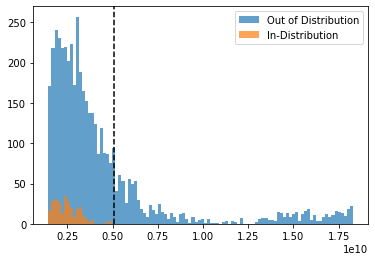

Normal: 3752 Anomaly: 1251


In [4]:
e8120_report, e8120_border = oc_svm_detector('e8120', e8120_trn_seq, e8120_gen_seq, TRN_FRAC, PRINT_SEQUENCES)

In [5]:
for s in e8120_trn_seq[:5]:
    print_seq_dsc(s)
    print()

========= START =========
========== DXS ==========
8600:Traum pneumothorax-close:Traumatic pneumothorax without mention of open wound into thorax
80702:Fracture two ribs-closed:Closed fracture of two ribs
========== PRS ==========
9352:Application of neck support
8801:Computerized axial tomography of abdomen
8741:Computerized axial tomography of thorax
========== END ==========

========= START =========
========== DXS ==========
9190:Abrasion NEC:Abrasion or friction burn of other, multiple, and unspecified sites, without mention of infection
8798:Open wound site NOS:Open wound(s) (multiple) of unspecified site(s), without mention of complication
8509:Concussion NOS:Concussion, unspecified
82525:Fx metatarsal-closed:Closed fracture of metatarsal bone(s)
========== PRS ==========
========== END ==========

========= START =========
========== DXS ==========
87340:Open wound of face NOS:Open wound of face, unspecified site, without mention of complication
8509:Concussion NOS:Concussion

In [6]:
n = e8120_report[e8120_report['score']<e8120_border]

for _,r in n[:5].iterrows():
    print(r['output'])

========= START =========
========== DXS ==========
82523:Fx cuboid-closed:Closed fracture of cuboid
82521:Fx astragalus-closed:Closed fracture of astragalus
825:Fracture of one or more tarsal and metatarsal bones:None
824:Fracture of ankle:None
82321:Fx shaft fibula-closed:Closed fracture of shaft of fibula alone
823:Fracture of tibia and fibula:None
808:Fracture of pelvis:None
8074:Flail chest:Flail chest
8072:Fracture of sternum-clos:Closed fracture of sternum
80705:Fracture five ribs-close:Closed fracture of five ribs
========== PRS ==========
========== END ==========

========= START =========
========== DXS ==========
87342:Open wound of forehead:Open wound of forehead, without mention of complication
========== PRS ==========
8838:Other computerized axial tomography
9359:Other immobilization, pressure, and attention to wound
8703:Computerized axial tomography of head
9352:Application of neck support
3893:Venous catheterization, not elsewhere classified
8659:Closure of skin and 

In [7]:
w = e8120_report[e8120_report['score']>e8120_border]

for _,r in w[:5].iterrows():
    print(r['output'])

========= START =========
========== DXS ==========
82021:Intertrochanteric fx-cl:Closed fracture of intertrochanteric section of neck of femur
========== PRS ==========
8952:Electrocardiogram
E8120:Unknown Code
7915:Closed reduction of fracture with internal fixation, femur
3893:Venous catheterization, not elsewhere classified
========== END ==========

========= START =========
========== DXS ==========
920:Contusion of face, scalp, and neck except eye(s):None
9110:Abrasion trunk:Abrasion or friction burn of trunk, without mention of infection
9100:Abrasion head:Abrasion or friction burn of face, neck, and scalp except eye, without mention of infection
87341:Open wound of cheek:Open wound of cheek, without mention of complication
87340:Open wound of face NOS:Open wound of face, unspecified site, without mention of complication
8730:Open wound of scalp:Open wound of scalp, without mention of complication
86121:Lung contusion-closed:Contusion of lung without mention of open wound into 

# E885.9

100%|███████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.94it/s]
/home/paul/Stemmler/StemmlerProject/mdf.py:48: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/home/paul/Stemmler/StemmlerProject/mdf.py:49: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)
 82%|████████████████████████████████████████████████████▎           | 9/11 [00:00<00:00, 11.54it/s]/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) +

 AUROC  DTACC  AUIN   AUOUT 
 70.13  63.70  30.63  96.49
best hyper linear-0.1
saving data for plotting
-------------------------------


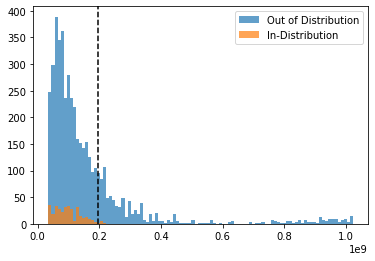

Normal: 3750 Anomaly: 1250


In [8]:
e8859_report, e8859_border = oc_svm_detector('e8859', e8859_trn_seq, e8859_gen_seq, TRN_FRAC, PRINT_SEQUENCES)

In [9]:
for s in e8859_trn_seq[:5]:
    print_seq_dsc(s)
    print()

========= START =========
========== DXS ==========
85300:Traumatic brain hem NEC:Other and unspecified intracranial hemorrhage following injury without mention of open intracranial wound, unspecified state of consciousness
8730:Open wound of scalp:Open wound of scalp, without mention of complication
========== PRS ==========
0139:Other incision of brain
========== END ==========

========= START =========
========== DXS ==========
82021:Intertrochanteric fx-cl:Closed fracture of intertrochanteric section of neck of femur
81201:Fx surg nck humerus-clos:Closed fracture of surgical neck of humerus
========== PRS ==========
7901:Closed reduction of fracture without internal fixation, humerus
0033:Computer assisted surgery with fluoroscopy
7935:Open reduction of fracture with internal fixation, femur
========== END ==========

========= START =========
========== DXS ==========
83101:Ant disloc humerus-close:Closed anterior dislocation of humerus
81209:Fx upper humerus NEC-cl:Other closed 

In [10]:
n = e8859_report[e8859_report['score']<e8859_border]

for _,r in n[:5].iterrows():
    print(r['output'])

========= START =========
========== DXS ==========
87342:Open wound of forehead:Open wound of forehead, without mention of complication
82021:Intertrochanteric fx-cl:Closed fracture of intertrochanteric section of neck of femur
========== PRS ==========
8952:Electrocardiogram
8952:Electrocardiogram
9396:Other oxygen enrichment
========== END ==========

========= START =========
========== DXS ==========
83813:Disl tarsometatarsal-opn:Open dislocation of tarsometatarsal (joint)
8371:Dislocation ankle-open:Open dislocation of ankle
82535:Fx metatarsal-open:Open fracture of metatarsal bone(s)
========== PRS ==========
7987:Open reduction of dislocation of ankle
7908:Closed reduction of fracture without internal fixation, phalanges of foot
========== END ==========

========= START =========
========== DXS ==========
80230:Mandible fx NOS-open:Open fracture of mandible, unspecified site
8020:Nasal bone fx-closed:Closed fracture of nasal bones
========== PRS ==========
9355:Dental wiring


In [11]:
w = e8859_report[e8859_report['score']>e8859_border]

for _,r in w[:5].iterrows():
    print(r['output'])

========= START =========
========== DXS ==========
92401:Contusion of hip:Contusion of hip
920:Contusion of face, scalp, and neck except eye(s):None
85220:Traumatic subdural hem:Subdural hemorrhage following injury without mention of open intracranial wound, unspecified state of consciousness
85200:Traum subarachnoid hem:Subarachnoid hemorrhage following injury without mention of open intracranial wound, unspecified state of consciousness
85100:Cerebral cortx contusion:Cortex (cerebral) contusion without mention of open intracranial wound, unspecified state of consciousness
========== PRS ==========
========== END ==========

========= START =========
========== DXS ==========
8730:Open wound of scalp:Open wound of scalp, without mention of complication
========== PRS ==========
8703:Computerized axial tomography of head
8876:Diagnostic ultrasound of abdomen and retroperitoneum
9352:Application of neck support
8838:Other computerized axial tomography
========== END ==========

=======

# E966.0

100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 17.84it/s]
/home/paul/Stemmler/StemmlerProject/mdf.py:48: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/home/paul/Stemmler/StemmlerProject/mdf.py:49: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)
 82%|████████████████████████████████████████████████████▎           | 9/11 [00:00<00:00, 12.33it/s]/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) +

 AUROC  DTACC  AUIN   AUOUT 
 73.76  66.30  33.84  97.07
best hyper linear-1e-12
saving data for plotting
-------------------------------


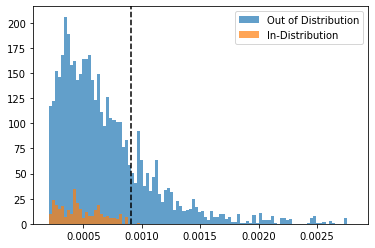

Normal: 3750 Anomaly: 1251


In [12]:
e9660_report, e9660_border = oc_svm_detector('e9660', e9660_trn_seq, e9660_gen_seq, TRN_FRAC, PRINT_SEQUENCES)

In [13]:
for s in e9660_trn_seq[:5]:
    print_seq_dsc(s)
    print()

========= START =========
========== DXS ==========
8792:Opn wnd anterior abdomen:Open wound of abdominal wall, anterior, without mention of complication
8760:Open wound of back:Open wound of back, without mention of complication
========== PRS ==========
9604:Insertion of endotracheal tube
3409:Other incision of pleura
5411:Exploratory laparotomy
========== END ==========

========= START =========
========== DXS ==========
8910:Open wnd knee/leg/ankle:Open wound of knee, leg [except thigh], and ankle, without mention of complication
8900:Open wound of hip/thigh:Open wound of hip and thigh, without mention of complication
88003:Open wound of upper arm:Open wound of upper arm, without mention of complication
8792:Opn wnd anterior abdomen:Open wound of abdominal wall, anterior, without mention of complication
8750:Open wound of chest:Open wound of chest (wall), without mention of complication
87342:Open wound of forehead:Open wound of forehead, without mention of complication
81602:Fx d

In [14]:
n = e9660_report[e9660_report['score']<e9660_border]

for _,r in n[:5].iterrows():
    print(r['output'])

========= START =========
========== DXS ==========
9033:Injury ulnar vessels:Injury to ulnar blood vessels
88122:Opn wound wrist w tendon:Open wound of wrist, with tendon involvement
========== PRS ==========
8659:Closure of skin and subcutaneous tissue of other sites
8364:Other suture of tendon
3931:Suture of artery
3883:Other surgical occlusion of vessels, upper limb vessels
8364:Other suture of tendon
========== END ==========

========= START =========
========== DXS ==========
9551:Injury median nerve:Injury to median nerve
9033:Injury ulnar vessels:Injury to ulnar blood vessels
88122:Opn wound wrist w tendon:Open wound of wrist, with tendon involvement
88120:Open wnd forearm w tendn:Open wound of forearm, with tendon involvement
========== PRS ==========
8364:Other suture of tendon
043:Suture of cranial and peripheral nerves
3883:Other surgical occlusion of vessels, upper limb vessels
========== END ==========

========= START =========
========== DXS ==========
8748:Open wound 

In [15]:
w = e9660_report[e9660_report['score']>e9660_border]

for _,r in w[:5].iterrows():
    print(r['output'])

========= START =========
========== DXS ==========
8604:Traum pneumohemothor-cl:Traumatic pneumohemothorax without mention of open wound into thorax
80711:Fracture one rib-open:Open fracture of one rib
========== PRS ==========
9604:Insertion of endotracheal tube
967:Unknown Code
3404:Insertion of intercostal catheter for drainage
3452:Thoracoscopic decortication of lung
========== END ==========

========= START =========
========== DXS ==========
88003:Open wound of upper arm:Open wound of upper arm, without mention of complication
8760:Open wound of back:Open wound of back, without mention of complication
========== PRS ==========
8659:Closure of skin and subcutaneous tissue of other sites
8879:Other diagnostic ultrasound
8744:Routine chest x-ray, so described
8878:Diagnostic ultrasound of gravid uterus
8741:Computerized axial tomography of thorax
========== END ==========

========= START =========
========== DXS ==========
8798:Open wound site NOS:Open wound(s) (multiple) of unsp

# E965.4

100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.12it/s]
/home/paul/Stemmler/StemmlerProject/mdf.py:48: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/home/paul/Stemmler/StemmlerProject/mdf.py:49: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)
 82%|████████████████████████████████████████████████████▎           | 9/11 [00:00<00:00, 13.80it/s]/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) +

 AUROC  DTACC  AUIN   AUOUT 
 81.57  73.62  45.04  98.18
best hyper linear-1e-15
saving data for plotting
-------------------------------


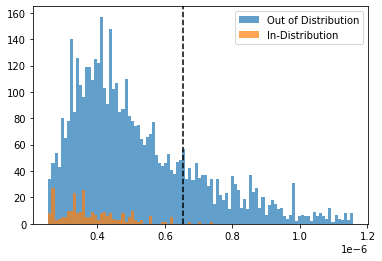

Normal: 3750 Anomaly: 1250


In [16]:
e9654_report, e9654_border = oc_svm_detector('e9654', e9654_trn_seq, e9654_gen_seq, TRN_FRAC, PRINT_SEQUENCES)

In [17]:
for s in e9654_trn_seq[:5]:
    print_seq_dsc(s)
    print()

========= START =========
========== DXS ==========
8053:Fx dorsal vertebra-open:Open fracture of dorsal [thoracic] vertebra without mention of spinal cord injury
8760:Open wound of back:Open wound of back, without mention of complication
30560:Cocaine abuse-unspec:Cocaine abuse, unspecified
30570:Amphetamine abuse-unspec:Amphetamine or related acting sympathomimetic abuse, unspecified
3051:Tobacco use disorder:Tobacco use disorder
========== PRS ==========
========== END ==========

========= START =========
========== DXS ==========
88003:Open wound of upper arm:Open wound of upper arm, without mention of complication
8605:Traum pneumohemothor-opn:Traumatic pneumohemothorax with open wound into thorax
80711:Fracture one rib-open:Open fracture of one rib
========== PRS ==========
3404:Insertion of intercostal catheter for drainage
3893:Venous catheterization, not elsewhere classified
3893:Venous catheterization, not elsewhere classified
9904:Transfusion of packed cells
5794:Insertion 

In [18]:
n = e9654_report[e9654_report['score']<e9654_border]

for _,r in n[:5].iterrows():
    print(r['output'])

========= START =========
========== DXS ==========
9598:Injury mlt site/site NEC:Other specified sites, including multiple injury
80239:Mult fx mandible-open:Open fracture of mandible, multiple sites
========== PRS ==========
8628:Nonexcisional debridement of wound, infection or burn
8659:Closure of skin and subcutaneous tissue of other sites
7676:Open reduction of mandibular fracture
7676:Open reduction of mandibular fracture
2432:Suture of laceration of gum
2752:Suture of laceration of other part of mouth
========== END ==========

========= START =========
========== DXS ==========
80040:Cl skl vlt fx/br inj NEC:Closed fracture of vault of skull with intracranial injury of other and unspecified nature, unspecified state of consciousness
8760:Open wound of back:Open wound of back, without mention of complication
82521:Fx astragalus-closed:Closed fracture of astragalus
95892:Trauma comp synd low ext:Traumatic compartment syndrome of lower extremity
========== PRS ==========
8314:Fasc

In [19]:
w = e9654_report[e9654_report['score']>e9654_border]

for _,r in w[:5].iterrows():
    print(r['output'])

========= START =========
========== DXS ==========
95892:Trauma comp synd low ext:Traumatic compartment syndrome of lower extremity
8901:Open wnd hip/thigh-compl:Open wound of hip and thigh, complicated
90289:Inj abdominal vessel NEC:Injury to other specified blood vessels of abdomen and pelvis
86389:GI injury NEC-closed:Injury to other gastrointestinal sites, without mention of open wound into cavity
86329:Small intest inj NEC-cl:Other injury to small intestine, without mention of open wound into cavity
8089:Pelvic fracture NOS-open:Open unspecified fracture of pelvis
65641:Intrauter death-deliver:Intrauterine death, affecting management of mother, delivered, with or without mention of antepartum condition
56081:Intestinal adhes w obstr:Intestinal or peritoneal adhesions with obstruction (postoperative) (postinfection)
2851:Ac posthemorrhag anemia:Acute posthemorrhagic anemia
========== PRS ==========
========== END ==========

========= START =========
========== DXS ==========
8792

# E924.0

100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 17.79it/s]
/home/paul/Stemmler/StemmlerProject/mdf.py:48: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/home/paul/Stemmler/StemmlerProject/mdf.py:49: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)
 82%|████████████████████████████████████████████████████▎           | 9/11 [00:00<00:00, 11.83it/s]/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) +

 AUROC  DTACC  AUIN   AUOUT 
 82.75  75.03  56.51  97.91
best hyper linear-0.5
saving data for plotting
-------------------------------


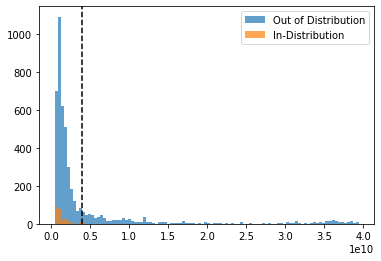

Normal: 3750 Anomaly: 1251


In [20]:
e9240_report, e9240_border = oc_svm_detector('e9240', e9240_trn_seq, e9240_gen_seq, TRN_FRAC, PRINT_SEQUENCES)

In [21]:
for s in e9240_trn_seq[:5]:
    print_seq_dsc(s)
    print()

========= START =========
========== DXS ==========
94222:2nd deg burn chest wall:Blisters, epidermal loss [second degree] of chest wall, excluding breast and nipple
94223:2nd deg burn abdomn wall:Blisters, epidermal loss [second degree] of abdominal wall
94224:2nd deg burn back:Blisters, epidermal loss [second degree] of back [any part]
94325:2nd deg burn shoulder:Blisters, epidermal loss [second degree] of shoulder
94128:2nd deg burn neck:Blisters, epidermal loss [second degree] of neck
94121:2nd deg burn ear:Blisters, epidermal loss [second degree] of ear [any part]
94127:2nd deg burn face NEC:Blisters, epidermal loss [second degree] of forehead and cheek
94810:10-19% bdy brn/3 deg NOS:Burn [any degree] involving 10-19 percent of body surface with third degree burn, less than 10 percent or unspecified
========== PRS ==========
3893:Venous catheterization, not elsewhere classified
8628:Nonexcisional debridement of wound, infection or burn
9357:Application of other wound dressing
9333

In [22]:
n = e9240_report[e9240_report['score']<e9240_border]

for _,r in n[:5].iterrows():
    print(r['output'])

========= START =========
========== DXS ==========
94800:Bdy brn < 10%/3d deg NOS:Burn [any degree] involving less than 10 percent of body surface with third degree burn, less than 10 percent or unspecified
94532:3rd deg burn foot:Full-thickness skin loss [third degree NOS] of foot
========== PRS ==========
8622:Excisional debridement of wound, infection, or burn
8665:Heterograft to skin
8669:Other skin graft to other sites
========== END ==========

========= START =========
========== DXS ==========
948:Burns classified according to extent of body surface involved:None
94323:2nd deg burn upper arm:Blisters, epidermal loss [second degree] of upper arm
94224:2nd deg burn back:Blisters, epidermal loss [second degree] of back [any part]
========== PRS ==========
8628:Nonexcisional debridement of wound, infection or burn
9659:Other irrigation of wound
========== END ==========

========= START =========
========== DXS ==========
948:Burns classified according to extent of body surface in

In [23]:
w = e9240_report[e9240_report['score']>e9240_border]

for _,r in w[:5].iterrows():
    print(r['output'])

========= START =========
========== DXS ==========
948:Burns classified according to extent of body surface involved:None
========== PRS ==========
8628:Nonexcisional debridement of wound, infection or burn
8628:Nonexcisional debridement of wound, infection or burn
8628:Nonexcisional debridement of wound, infection or burn
8628:Nonexcisional debridement of wound, infection or burn
========== END ==========

========= START =========
========== DXS ==========
94810:10-19% bdy brn/3 deg NOS:Burn [any degree] involving 10-19 percent of body surface with third degree burn, less than 10 percent or unspecified
94333:3rd deg burn upper arm:Full-thickness skin loss [third degree, not otherwise specified] of upper arm
94324:2nd deg burn axilla:Blisters, epidermal loss [second degree] of axilla
94128:2nd deg burn neck:Blisters, epidermal loss [second degree] of neck
94125:2nd deg burn nose:Blisters, epidermal loss [second degree] of nose (septum)
========== PRS ==========
========== END =======